# Human Correlation Analysis

Fork from https://github.com/facebookresearch/ParlAI/blob/master/projects/controllable_dialogue/Analysis_n_Graphs.ipynb

### General preparation

In [3]:
# bunch of imports and settings
import os
# make sure we never use CUDA on accident in this notebook
os.environ['CUDA_VISIBLE_DEVICES'] = ''

import logging
logging.basicConfig(level=logging.WARNING, format='%(message)s')

# Make the notebook bigger
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12.0, 8.0]

import contextlib
import numpy as np
import scipy.stats
import logging
import time
import matplotlib.pyplot as plt


import torch
from torch import nn
import torch.nn.functional as F

import pyro
import pyro.infer
import pyro.infer.mcmc
import pyro.distributions as dist
from parlai.core.metrics import _f1_score, _bleu

pyro.enable_validation(False)

import pandas as pd
import json
import os
import seaborn as sns
from pprint import pprint
pd.options.display.float_format = '{:,.4f}'.format

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
pd.set_option('display.max_columns', 500)



import projects.controllable_dialogue.controllable_seq2seq.controls as control
import projects.controllable_dialogue.controllable_seq2seq.nidf as nidf
import projects.controllable_dialogue.controllable_seq2seq.arora as arora
import parlai.core.dict as pcdict

In [4]:
# Get where the logs are stored
from parlai.core.params import ParlaiParser
basic_opt = ParlaiParser().parse_args([], print_args=False)

# make sure we download everything
from projects.controllable_dialogue.tasks.build import build
build(basic_opt)

DATA_FOLDER = os.path.join(basic_opt['datapath'], 'controllable_dialogue')
LOG_FOLDER = os.path.join(DATA_FOLDER, 'evaluation_logs')

# used for assertions later
NUM_TURNS = 6

# names of metrics
LIKERT_METRICS = ['fluency', 'enjoy', 'turing', 'make_sense', 'inquisitive', 'interest', 'avoid_rep', 'listen']

## Helper functions

In [5]:
# IO utilities
def render_conversation(row):
    result = []
    nice_scores = '&nbsp;&nbsp;&nbsp;&nbsp;'.join([
        '{}: {}'.format(m.title(), row[m])
        for m in LIKERT_METRICS
    ])
    for i, turn in enumerate(row['dialog']):
        is_bot = turn['speaker'] == 'model'
        speakername = row['model_name'] if is_bot else 'Human'
        text = turn['text']
        
        align = 'right' if is_bot else 'left'
        color = "white" if is_bot else "black"
        bgcolor = '#2391f7' if is_bot else '#e1e1e7'
        
        result.append(
            (
                '<div style="overflow: auto; padding: 1ex 0;">'
                '<div style="clear: both; float: {}; color: {}; background-color: {}; padding: 0.5em 1em; border-radius: 1em; max-width: 80%">'
                '<p style="margin: 0">{}: {}</p>'
                '</div>'
                '</div>'
            )
            .format(align, color, bgcolor, speakername, text)
        )
    return HTML(
        '<div style="background-color: white; margin: 0em; padding: 0.5em; '
        'font-family: sans-serif; font-size: 12pt; width: 99%;">'
        + ''.join(result) +
        '</div>'
    )

def render_many_converstions(table):
    return HTML('<hr />\n'.join(render_conversation(r).data for i, r in table.iterrows()))

# useful helpers

def modelname_subset(data, model_keys):
    return data[data.model_name.apply(lambda x: x in model_keys)]

def modeltype_subset(data, model_keys):
    return data[data.model_type.apply(lambda x: x in model_keys)].sort_values(['model_type', 'model_bucket'])


## Load conversation table

In [6]:
conversation_table = []
workers = set()

def get_many_logs():
    for fn in os.listdir(LOG_FOLDER):
        with open(os.path.join(LOG_FOLDER, fn)) as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                yield json.loads(line)

for item in get_many_logs():
    row = {}
    
    # flatten out and get the keys we need
    
    for key in ['model_name', 'model_type', 'model_bucket', 'dialog', 'assignment_id_hashed', 'evaluator_id_hashed']:
        row[key] = item[key]
    
    for key in ['enjoy', 'interest', 'listen', 'turing', 'avoid_rep', 'make_sense', 'fluency', 'persona_guess', 'inquisitive']:
        row[key] = item['evaluation_results'][key]
    
    conversation_table.append(row)
    
conversation_table = pd.DataFrame(conversation_table)
# mark certain columns as categories
conversation_table['evaluator_id_hashed'] = conversation_table.evaluator_id_hashed.astype('category')
conversation_table['model_name'] = conversation_table.model_name.astype('category')

# deterministic shuffle
conversation_table = conversation_table.sort_values('assignment_id_hashed').sample(frac=1, random_state=42)


# Raw table at a glance

In [15]:
conversation_table[conversation_table.model_name == 'greedy_model']['dialog'].loc[768]

[{'speaker': 'human_evaluator', 'text': 'Hello! how are you?'},
 {'speaker': 'model',
  'text': "I'm doing well. Just got done playing some game of duty."},
 {'speaker': 'human_evaluator', 'text': 'What else do you enjoy doing?'},
 {'speaker': 'model', 'text': 'I like to play with my friends.'},
 {'speaker': 'human_evaluator',
  'text': 'That sounds fun. I like watching old war documentaries'},
 {'speaker': 'model', 'text': 'I like to play the game of duty.'},
 {'speaker': 'human_evaluator',
  'text': 'I enjoy eating cheeseburgers. Do you enjoy them aswel?'},
 {'speaker': 'model', 'text': 'I do. I love them.'},
 {'speaker': 'human_evaluator',
  'text': 'I also volunteer at a soup kitchen. Do you do any volunteer work?'},
 {'speaker': 'model',
  'text': 'I do. I volunteer at the local department store.'},
 {'speaker': 'human_evaluator',
  'text': 'That sounds like fun. What do you do for work?'},
 {'speaker': 'model', 'text': 'I am a student. I work at a grocery store.'}]

In [ ]:
## convert conversation table into context response pairs. 
## keep some identifier for the original row: assignment_id_hashed, evaluator_id_hashed
## response should start with speaker:model


In [17]:
conversation_table.loc[1870]['dialog']

[{'speaker': 'model', 'text': 'Hi how are you today'},
 {'speaker': 'human_evaluator', 'text': "I'm good how are you ?"},
 {'speaker': 'model', 'text': 'I am good do you work'},
 {'speaker': 'human_evaluator',
  'text': 'Yes I work at a tech company . WHat do you do ?'},
 {'speaker': 'model', 'text': "I'm a professional wrestler"},
 {'speaker': 'human_evaluator', 'text': "oh wow that's really cool "},
 {'speaker': 'model', 'text': 'What is your favorite color'},
 {'speaker': 'human_evaluator', 'text': 'I like red , you ?'},
 {'speaker': 'model', 'text': 'Yellow is my favorite'},
 {'speaker': 'human_evaluator', 'text': 'cool, do you like coffee ?'},
 {'speaker': 'model', 'text': 'Yes I do I love it'},
 {'speaker': 'human_evaluator', 'text': 'me too '}]

In [19]:
def get_cont_resp_pairs(dial):
    pairs = []
    context = []
    response = ''
    for di,d in enumerate(dial):
        if d['speaker'] == 'model':
            if len(context) > 0:
                response = d['text']
                pairs.append(('\n'.join(context), response))
        context.append(d['text'])
    return pairs

In [21]:
get_cont_resp_pairs(conversation_table.loc[768]['dialog'])

[('Hello! how are you?',
  "I'm doing well. Just got done playing some game of duty."),
 ("Hello! how are you?\nI'm doing well. Just got done playing some game of duty.\nWhat else do you enjoy doing?",
  'I like to play with my friends.'),
 ("Hello! how are you?\nI'm doing well. Just got done playing some game of duty.\nWhat else do you enjoy doing?\nI like to play with my friends.\nThat sounds fun. I like watching old war documentaries",
  'I like to play the game of duty.'),
 ("Hello! how are you?\nI'm doing well. Just got done playing some game of duty.\nWhat else do you enjoy doing?\nI like to play with my friends.\nThat sounds fun. I like watching old war documentaries\nI like to play the game of duty.\nI enjoy eating cheeseburgers. Do you enjoy them aswel?",
  'I do. I love them.'),
 ("Hello! how are you?\nI'm doing well. Just got done playing some game of duty.\nWhat else do you enjoy doing?\nI like to play with my friends.\nThat sounds fun. I like watching old war documentaries

In [40]:
ref_rows = {'context': [], 'response': [], 'assignment_id_hashed': [], 'evaluator_id_hashed': []}
for i,row in conversation_table.iterrows():
    pairs = get_cont_resp_pairs(row['dialog'])
    for pair in pairs:
        ref_rows['context'].append(pair[0].lower())
        ref_rows['response'].append(pair[1].lower())
        ref_rows['assignment_id_hashed'].append(row['assignment_id_hashed'])
        ref_rows['evaluator_id_hashed'].append(row['evaluator_id_hashed'])

In [41]:
ref_pd = pd.DataFrame(ref_rows)

In [326]:
len(ref_pd)

18265

### Bayesian Score computation (Kulikov, 2019)

In [180]:
# map back from model name to type/bucket
rmap = {}
for _, row in conversation_table.iterrows():
    model_name = row['model_name']
    if model_name not in rmap:
        rmap[model_name] = (row['model_bucket'], row['model_type'])

def infer_single_scores(table, fieldname, num_samples=100, warmup_steps=50):
    import torch
    torch.set_num_threads(1)
    t0 = time.time()
    observed_single_scores = torch.Tensor(list(table[fieldname]))
    num_likert_options = table[fieldname].nunique()
    
    def model_single_score(table):
        '''
        prior for each algorithm a
        p(m_a) = Unif(1, num_likert_options)

        prior for each single score given the models sampled mean
        p(s_a) = N(s_a|m_a, 1^2)
        '''
        zm = []
        for mi in range(table.model_name.nunique()):
            mu_ = pyro.sample("model-mean-{}".format(mi), dist.Uniform(1., float(num_likert_options)))
            zm.append(pyro.sample("model-{}".format(mi), dist.Normal(mu_, 1.)))

        '''
        prior for each turker's bias
        p(s_t) = N(s_t | 0, 1^2) - i.e., no bias from each turker a priori
        '''
        tm = []
        for ti in range(table.evaluator_id_hashed.nunique()):
            tm.append(pyro.sample("turker-mean-{}".format(ti), dist.Normal(0., 1.)))

        '''
        likelihood mean for each score (algorithm, score)
        p(s|a, t) = N(s| s_a + s_t, 1^2)
        '''
        mu = []
        for worker_id, model_id in zip(table.evaluator_id_hashed.cat.codes, table.model_name.cat.codes):
            mu.append(zm[model_id] + tm[worker_id])
        mu_ = torch.stack(mu)

        return pyro.sample("scores", dist.Normal(mu_, 1.))

    single_score_condition = pyro.condition(
            model_single_score, 
            data={'scores': observed_single_scores}
    )
    nuts_kernel = pyro.infer.mcmc.NUTS(single_score_condition, adapt_step_size=True, step_size=0.1)
    mcmc_run = pyro.infer.mcmc.MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps).run(table)
    
    score_marginal = pyro.infer.EmpiricalMarginal(
        mcmc_run,
        sites=["model-{}".format(mi) for mi in range(table.model_name.nunique())]
    )
    print('time taken: ', time.time()-t0)
    
    
    df = pd.DataFrame({
        'model_name': table.model_name.cat.categories,
        fieldname + '_mean': score_marginal.mean,
        fieldname + '_std': score_marginal.stddev
    })
    df['model_bucket'] = [rmap[mn][0] for mn in df['model_name']]
    df['model_type'] = [rmap[mn][1] for mn in df['model_name']]

    return df.set_index('model_name')


The following step runs bayesian analysis for each of the measures in parallel. You will want to decrease the number of CPUs down to what your computer has. The process takes about 45 minutes to compute.

Due to the stochastic nature of the process, you will get slightly different numbers than the ones reported in the paper. For convenience, we've included the ones from the paper to avoid this computation

In [520]:
def get_bayesian_cor_scores(run_model=False):
    if run_model:
        # run all the scores in parallel and join the results into one table

        # torch freaks out if we try to multiprocess with cuda
        import os
        os.environ['CUDA_VISIBLE_DEVICES'] = ''
        # keep each of the threads from stomping all over each other
        torch.set_num_threads(1)

        from multiprocessing import Pool

        with Pool(20) as pool:
            args = [(conversation_table, measure) for measure in LIKERT_METRICS]
            results_bayes = pd.concat(pool.starmap(infer_single_scores, args), axis=1)
    else:
        bayes_data = '''
        model_name,fluency_mean,fluency_std,enjoy_mean,enjoy_std,turing_mean,turing_std,make_sense_mean,make_sense_std,inquisitive_mean,inquisitive_std,interest_mean,interest_std,avoid_rep_mean,avoid_rep_std,listen_mean,listen_std,model_type,model_bucket
    baseline_model,3.0914075,0.12956531,2.2892258,0.10683544,1.7131442,0.13138857,3.345498,0.12607269,2.4151554,0.10993455,2.2880845,0.1420951,2.0833843,0.10571904,2.4713647,0.117826685,baseline,
    greedy_model,3.0280933,0.10491706,2.2354803,0.107257016,1.7464366,0.11817865,3.233947,0.10319092,1.9487315,0.102352,2.290578,0.12559834,2.0841112,0.103310645,2.6239514,0.10315127,greedy,
    human_eval,3.3617704,0.11792514,3.0442827,0.11493982,3.350734,0.113348715,3.681538,0.10894737,2.435449,0.11926911,2.9190917,0.111999035,2.790789,0.11871563,3.3168595,0.12881786,human,
    inquisitive_model_ct_setting00,3.5139592,0.0967675,2.83884,0.12611441,2.4591095,0.10882996,3.4932463,0.119373344,2.3637252,0.09294756,2.7555757,0.0927458,2.8722908,0.11721186,3.1028264,0.09619383,inquisitive-ct,000
    inquisitive_model_ct_setting01,3.4174926,0.10161546,2.876931,0.10879339,2.458943,0.11697992,3.549381,0.09925039,2.4650643,0.10826402,2.7947018,0.12823951,2.816174,0.109138474,3.138592,0.11414942,inquisitive-ct,001
    inquisitive_model_ct_setting04,3.466806,0.11303423,2.8775582,0.09969538,2.4028935,0.09169132,3.5896442,0.09606155,2.5327814,0.12658662,2.830341,0.1268796,2.783972,0.122446634,3.2362282,0.10941788,inquisitive-ct,004
    inquisitive_model_ct_setting07,3.5384107,0.0939107,2.9888,0.105407335,2.3539126,0.11059914,3.474378,0.10486635,2.6636062,0.119133025,2.9173691,0.117349364,2.8096406,0.1004062,3.1082954,0.09788587,inquisitive-ct,007
    inquisitive_model_ct_setting10,3.5227299,0.12035936,2.8661678,0.11492953,2.3464699,0.11804114,3.5265877,0.12227977,2.6337807,0.11855745,2.6558821,0.10226053,2.6730306,0.12550566,2.9447966,0.109267645,inquisitive-ct,010
    inquisitive_model_ct_setting10_better,3.420784,0.12406063,2.7386124,0.09353278,2.1931195,0.13429101,3.450729,0.13293721,2.7863073,0.111801624,2.7376783,0.111998275,2.6759079,0.11800891,2.9955559,0.12491749,inquisitive-ct,011
    interesting_nidf_model_bfw_setting_04,3.4463646,0.13350625,2.9587107,0.12454782,2.4409015,0.11551093,3.5361714,0.10621155,2.5572858,0.08596149,2.9410334,0.11254286,2.840033,0.10043833,3.1984024,0.09754762,nidf_bfw,004
    interesting_nidf_model_bfw_setting_06,3.3424668,0.09006725,2.9053752,0.097677216,2.3083365,0.11380971,3.4079204,0.116244145,2.5260317,0.11763178,2.9328823,0.119851254,2.8065453,0.09133208,3.0851126,0.09660692,nidf_bfw,006
    interesting_nidf_model_bfw_setting_08,2.5359437,0.11638034,2.3928986,0.12092932,1.8046832,0.12724209,2.8720655,0.11232278,2.0019753,0.097686924,2.4934795,0.11799547,2.7020395,0.10965349,2.4661036,0.10257839,nidf_bfw,008
    interesting_nidf_model_bfw_setting_minus_04,3.3714204,0.102036715,2.7597752,0.11824679,2.3626835,0.10884776,3.5159597,0.108949505,2.4624243,0.110119894,2.621436,0.11877783,2.8268204,0.10388491,3.1394558,0.094563544,nidf_bfw,-04
    interesting_nidf_model_bfw_setting_minus_10,3.188879,0.12436492,2.4090981,0.12411542,2.1500096,0.1128042,3.2827806,0.11560405,2.2804828,0.1344875,2.351124,0.121478364,2.7615042,0.11347523,2.886509,0.10520854,nidf_bfw,-10
    interesting_nidf_model_ct_setting0,3.4431455,0.11906912,2.9258559,0.088641025,2.3770676,0.11373025,3.6066294,0.10947405,2.5631077,0.122011304,2.8404248,0.12301018,2.788957,0.096725754,3.1246283,0.12607282,nidf_ct,000
    interesting_nidf_model_ct_setting2,3.389251,0.13110022,2.7392132,0.11038114,2.3120344,0.12750752,3.4655373,0.10412794,2.5648835,0.12711605,2.7370658,0.11907516,2.781668,0.119834706,2.9915996,0.10762761,nidf_ct,002
    interesting_nidf_model_ct_setting4,3.4366372,0.13992369,2.795612,0.1315953,2.3171048,0.13324456,3.4565122,0.12817147,2.5133355,0.11968733,2.7807126,0.15289873,2.8235056,0.098016724,3.085936,0.12654012,nidf_ct,004
    interesting_nidf_model_ct_setting7,3.4267304,0.11089812,2.91389,0.13190652,2.4536288,0.095813766,3.5490704,0.109761,2.4927237,0.11294685,2.8147955,0.121712856,2.812701,0.12364607,3.1512172,0.12203714,nidf_ct,007
    interesting_nidf_model_ct_setting9,3.412071,0.11562859,2.7782488,0.09793116,2.3476672,0.13273424,3.5078192,0.123752415,2.2768347,0.10855014,2.791978,0.10660777,2.7957282,0.1290695,2.9055562,0.10904883,nidf_ct,009
    repetition_model_setting05,3.351136,0.12485303,2.5351877,0.11802207,2.131792,0.11483303,3.4810336,0.11032247,2.633227,0.11012598,2.5645876,0.11315254,2.6154072,0.10460297,2.925591,0.11182627,repetition-bfw,2gram=005
    repetition_model_setting12,3.403044,0.12195272,2.818021,0.12892646,2.2676632,0.12410987,3.5339706,0.138091,2.5448759,0.08994768,2.7566962,0.1035419,2.7767127,0.09308626,3.0484388,0.110010505,repetition-bfw,2gram=012
    repetition_model_setting35,3.562523,0.102048345,2.934537,0.09988889,2.4272463,0.107678376,3.6171374,0.12241684,2.47073,0.10978695,2.8317904,0.09658501,2.826065,0.11344152,3.1369538,0.10203378,repetition-bfw,2gram=035
    repetition_model_setting35_settinginf,3.5319638,0.10463153,2.8183765,0.12304195,2.3975408,0.10982047,3.5779467,0.14254314,2.62365,0.1294855,2.843848,0.12449841,2.8550565,0.12010231,3.103962,0.109406754,repetition-bfw,2gram=035 stop=inf
    repetition_model_settinginf,3.4903002,0.12059033,2.874239,0.1358771,2.3232102,0.1309247,3.5929792,0.116237886,2.555877,0.10959805,2.7502258,0.11547001,2.7356553,0.114207745,3.127551,0.11856033,repetition-bfw,2gram=999
    responsiveness_model_bfw_setting_00,3.5512834,0.087748855,2.9677284,0.11360309,2.6231253,0.10570546,3.7040608,0.10423539,2.4773164,0.100650065,2.8829346,0.11615346,2.8743443,0.115949884,3.2102318,0.09360844,responsive,000
    responsiveness_model_bfw_setting_05,3.3485637,0.12327652,2.8315463,0.09458454,2.398068,0.11602921,3.407857,0.115517996,2.506635,0.12592898,2.803587,0.12773731,2.7892473,0.10135295,3.1325374,0.11519348,responsive,005
    responsiveness_model_bfw_setting_10,2.9316738,0.11106751,2.4206061,0.11819174,1.9520544,0.122140095,3.1197522,0.09797036,2.1957242,0.11881691,2.5557888,0.11651121,2.7393322,0.10824369,2.9012582,0.12356319,responsive,010
    responsiveness_model_bfw_setting_13,2.397673,0.08854504,2.0601296,0.10622171,1.7427883,0.11313255,2.6316466,0.10069777,2.0721536,0.10736318,2.2488096,0.11831513,2.6300664,0.12108313,2.486768,0.1420562,responsive,013
    responsiveness_model_bfw_setting_minus_10,3.2559185,0.10904983,2.4534166,0.122486725,1.9554462,0.10266632,3.1158836,0.11584097,2.312914,0.1201041,2.473524,0.119496204,2.7670064,0.11804217,2.7265708,0.108767524,responsive,-10
        '''.strip()
        import io
        results_bayes = pd.read_csv(io.StringIO(bayes_data)).set_index('model_name')

    results_bayes.index = results_bayes.index.str.strip()
    # things that have two names
    results_bayes.loc['repetition++'] = results_bayes.loc['responsiveness_model_bfw_setting_00']
    results_bayes.loc['repetition++','model_type'] = 'repetition-bfw'

    results_bayes.loc['interesting_nidf_model_bfw_setting_00'] = results_bayes.loc['repetition_model_setting35_settinginf']
    results_bayes.loc['interesting_nidf_model_bfw_setting_00','model_type'] = 'nidf_bfw'
    results_bayes.loc['interesting_nidf_model_bfw_setting_00','model_bucket'] = '00'

    results_bayes.loc['inquisitive_model_ct_setting10_better', 'model_bucket'] = '12'

    # prep results
    altered = results_bayes.copy().reset_index()
    altered["model_bucket"] = altered.model_bucket.astype('category')
    return results_bayes, altered

results_bayes, altered = get_bayesian_cor_scores()

In [468]:
def get_corr(key, df, method='spearman'):
    scores = []
    for col in df.columns:
        if '_mean' in col:
            scores.append((col.split('_mean')[0], df[col].corr(df[key], method='spearman')))
    return scores

# Dialog Metric correlation with Uncalibrated and Calibrated Scores

- Run inference using inference.sh script
- Read controllable_dialogs.csv
- combine the files
- add the column to bayesian calibration
- get the `altered` file
- plot the uncalibrated correlation
- print the calibrated correlation

In [540]:
raw_scores = pd.read_csv('output_data/controllable_dialogs.csv')
conv_scores = raw_scores.groupby(['assignment_id_hashed']).mean().reset_index()
conv_dial_scores = pd.merge(conversation_table, conv_scores, on='assignment_id_hashed')

def get_calibrated_score(col_name):
    scores = conv_dial_scores.groupby(['model_name']).mean()[col_name]
    results_bayes, _ = get_bayesian_cor_scores()
    results_bayes[col_name] = scores
    altered = results_bayes.copy().reset_index()
    altered["model_bucket"] = altered.model_bucket.astype('category')
    cor_scores = get_corr(col_name,altered)
    mean_score = np.mean([sc[-1] for sc in cor_scores])
    return cor_scores, mean_score

In [541]:
conv_dial_scores.columns

Index(['model_name', 'model_type', 'model_bucket', 'dialog',
       'assignment_id_hashed', 'evaluator_id_hashed', 'enjoy', 'interest',
       'listen', 'turing', 'avoid_rep', 'make_sense', 'fluency',
       'persona_guess', 'inquisitive', 'Unnamed: 0', 'Unnamed: 0.1',
       'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'Unnamed: 0.1.1.1.1',
       'Unnamed: 0.1.1.1.1.1', 'Unnamed: 0.1.1.1.1.1.1',
       'Unnamed: 0.1.1.1.1.1.1.1', 'Unnamed: 0.1.1.1.1.1.1.1.1',
       'Unnamed: 0.1.1.1.1.1.1.1.1.1', 'Unnamed: 0.1.1.1.1.1.1.1.1.1.1',
       'Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1',
       'Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1',
       'Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1',
       'Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1',
       'Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1', 'score_19334597',
       'score_20330191', 'score_20391351', 'score_0', 'bertnli_all_score_0',
       'infersent_all_score_0', 'infersent_all_score_20495233',
       'bertnli_all_score_20497378', 'na_all_score_20488119',
       'na_a

In [530]:
get_calibrated_score('na_all_score_20488119')

([('fluency', 0.36995073891625607),
  ('enjoy', 0.23152709359605908),
  ('turing', 0.09458128078817732),
  ('make_sense', 0.20788177339901473),
  ('inquisitive', 0.7275862068965516),
  ('interest', 0.24039408866995068),
  ('avoid_rep', -0.0354679802955665),
  ('listen', 0.11182266009852214)],
 0.24353448275862064)

In [539]:
get_calibrated_score('na_all_context_score_20488123')

([('fluency', 0.40788177339901466),
  ('enjoy', 0.1133004926108374),
  ('turing', 0.09507389162561573),
  ('make_sense', 0.2157635467980295),
  ('inquisitive', 0.6443349753694579),
  ('interest', 0.05566502463054186),
  ('avoid_rep', -0.04581280788177339),
  ('listen', 0.07684729064039407)],
 0.19538177339901475)

In [529]:
get_calibrated_score('bertnli_all_score_20497378')

([('fluency', 0.44334975369458113),
  ('enjoy', 0.19211822660098518),
  ('turing', 0.12906403940886696),
  ('make_sense', 0.25615763546798026),
  ('inquisitive', 0.5980295566502462),
  ('interest', 0.13546798029556648),
  ('avoid_rep', -0.038916256157635463),
  ('listen', 0.12364532019704431)],
 0.2298645320197044)

In [528]:
get_calibrated_score('infersent_all_score_20495233')

([('fluency', 0.24630541871921177),
  ('enjoy', 0.09113300492610836),
  ('turing', -0.10837438423645318),
  ('make_sense', 0.004926108374384235),
  ('inquisitive', 0.5891625615763546),
  ('interest', 0.11921182266009848),
  ('avoid_rep', -0.11773399014778321),
  ('listen', -0.08571428571428569)],
 0.0923645320197044)

In [545]:
inf_scores,inf_mean = get_calibrated_score('infersent_all_score_20495233')
bert_scores,bert_mean = get_calibrated_score('bertnli_all_score_20497378')
m_scores, m_mean = get_calibrated_score('na_all_score_20488119')
ruber_scores,ruber_mean = get_calibrated_score('ruber_all_score_20688482')

header = '''
\\begin{table}[]
\\centering
\\resizebox{\\textwidth}{!}{%
\\begin{tabular}{|l|l|l|l|l|}
\\hline
                     & RUBER & InferSent & DistilBERT NLI & \dtm{}          \\\\ \cline{2-4} 
'''
table = header + "\n"
for i in range(len(inf_scores)):
    row = "{}              & {} & {}     & {} & {}           \\\\".format(
        nice_metric_names[inf_scores[i][0]],
        round(ruber_scores[i][-1],3),
        round(inf_scores[i][-1],3),
        round(bert_scores[i][-1],3),
        round(m_scores[i][-1],3)
    )
    table += row + "\n"
table += "Mean                 & {} & {}     & {}          & {}  \\\\ \hline \n".format(round(ruber_mean,3), 
                                                                                        round(inf_mean,3),
                                                                             round(bert_mean,3), 
                                                                             round(m_mean,3))
footer = '''
\\end{tabular}%
}
\\caption{}
\\label{tab:my-table}
\\end{table}
'''
table += footer
print(table)


\begin{table}[]
\centering
\resizebox{\textwidth}{!}{%
\begin{tabular}{|l|l|l|l|l|}
\hline
                     & RUBER & InferSent & DistilBERT NLI & \dtm{}          \\ \cline{2-4} 

Fluency              & 0.322 & 0.246     & 0.443 & 0.37           \\
Engagingness              & 0.204 & 0.091     & 0.192 & 0.232           \\
Humanness              & 0.057 & -0.108     & 0.129 & 0.095           \\
Making Sense              & 0.0 & 0.005     & 0.256 & 0.208           \\
Inquisitiveness              & 0.583 & 0.589     & 0.598 & 0.728           \\
Interestingness              & 0.275 & 0.119     & 0.135 & 0.24           \\
Avoiding Repetition              & 0.093 & -0.118     & -0.039 & -0.035           \\
Listening              & 0.061 & -0.086     & 0.124 & 0.112           \\
Mean                 & 0.199 & 0.092     & 0.23          & 0.244  \\ \hline 

\end{tabular}%
}
\caption{}
\label{tab:my-table}
\end{table}



In [531]:
nice_metric_names

{'enjoy': 'Engagingness',
 'interest': 'Interestingness',
 'inquisitive': 'Inquisitiveness',
 'listen': 'Listening',
 'avoid_rep': 'Avoiding Repetition',
 'fluency': 'Fluency',
 'make_sense': 'Making Sense',
 'turing': 'Humanness',
 'persona_guess': 'Persona retrieval'}

In [486]:
results_bayes['agg_scores_bertnli_all_score_20497378']

model_name
baseline_model                                0.9538
greedy_model                                  0.8436
human_eval                                    0.8586
inquisitive_model_ct_setting00                0.9323
inquisitive_model_ct_setting01                0.9347
inquisitive_model_ct_setting04                0.9343
inquisitive_model_ct_setting07                0.9489
inquisitive_model_ct_setting10                0.9507
inquisitive_model_ct_setting10_better         0.9540
interesting_nidf_model_bfw_setting_04         0.9255
interesting_nidf_model_bfw_setting_06         0.9191
interesting_nidf_model_bfw_setting_08         0.7591
interesting_nidf_model_bfw_setting_minus_04   0.9226
interesting_nidf_model_bfw_setting_minus_10   0.8243
interesting_nidf_model_ct_setting0            0.9073
interesting_nidf_model_ct_setting2            0.9346
interesting_nidf_model_ct_setting4            0.9320
interesting_nidf_model_ct_setting7            0.9359
interesting_nidf_model_ct_setting9 

In [449]:
conv_scores = ref_pd.groupby(['assignment_id_hashed']).mean().reset_index()

In [450]:
len(conv_scores)

3316

In [451]:
len(conversation_table)

3316

In [452]:
conv_dial_scores = pd.merge(conversation_table, conv_scores, on='assignment_id_hashed')

In [152]:
conv_dial_scores.enjoy.corr(conv_dial_scores.score_scaled, method='pearson')

0.09344302486399793

In [153]:
conv_dial_scores.avoid_rep.corr(conv_dial_scores.score_scaled, method='pearson')

0.0004669133812781183

In [154]:
conv_dial_scores.interest.corr(conv_dial_scores.score_scaled, method='pearson')

0.09397982699407251

In [282]:
conv_dial_scores.columns

Index(['model_name', 'model_type', 'model_bucket', 'dialog',
       'assignment_id_hashed', 'evaluator_id_hashed', 'enjoy', 'interest',
       'listen', 'turing', 'avoid_rep', 'make_sense', 'fluency',
       'persona_guess', 'inquisitive', 'Unnamed: 0', 'Unnamed: 0.1',
       'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'Unnamed: 0.1.1.1.1',
       'Unnamed: 0.1.1.1.1.1', 'Unnamed: 0.1.1.1.1.1.1', 'score_19334597',
       'score_20330191', 'score_20391351', 'score_0', 'bertnli_all_score_0',
       'infersent_all_score_0'],
      dtype='object')

In [283]:
test_types = ['enjoy','interest','listen','avoid_rep','make_sense','fluency','inquisitive','turing']

In [221]:
scores = []
for mtype in test_types:
    print(mtype,conv_dial_scores[mtype].corr(conv_dial_scores.score_0, method='kendall'))
    scores.append(conv_dial_scores[mtype].corr(conv_dial_scores.score_0, method='kendall'))

enjoy 0.08602107366129597
interest 0.08821480748281132
listen 0.0783164490887421
avoid_rep 0.07118716983823027
make_sense 0.09135284281407176
fluency 0.10563288603487597
inquisitive 0.12936325812927255


In [214]:
import numpy as np

In [222]:
np.mean(scores)

0.09286978386418569

In [223]:
scores = []
for mtype in test_types:
    print(mtype,conv_dial_scores[mtype].corr(conv_dial_scores.bertnli_all_score_0, method='kendall'))
    scores.append(conv_dial_scores[mtype].corr(conv_dial_scores.bertnli_all_score_0, method='kendall'))

enjoy 0.10316885644372972
interest 0.10598186323046807
listen 0.04510542416643879
avoid_rep 0.03612531684214653
make_sense 0.07304776439309989
fluency 0.07427830606483474
inquisitive 0.1990903307913153


In [224]:
np.mean(scores)

0.09097112313314759

In [242]:
def get_scores(df, key, method='spearman'):
    scores = []
    for mtype in test_types:
        scores.append((mtype, df[mtype].corr(df[key], method='spearman')))
    return scores

In [340]:
def get_scores_scipy(df, key, method='spearman'):
    scores = []
    for mtype in test_types:
        if method  == 'pearson':
            scores.append(pearsonr(df[mtype].to_list(),df[key].to_list()))
        if method  == 'spearman':
            scores.append(spearmanr(df[mtype].to_list(),df[key].to_list()))
    return scores

In [344]:
get_scores_scipy(conv_dial_scores, 'na_all_score_20488119', 'spearman')

[SpearmanrResult(correlation=0.14212230957951297, pvalue=1.988749732661066e-16),
 SpearmanrResult(correlation=0.13446650594302947, pvalue=7.507101652775365e-15),
 SpearmanrResult(correlation=0.09979809372204594, pvalue=8.458343194094414e-09),
 SpearmanrResult(correlation=0.033006808013577, pvalue=0.05736897778294621),
 SpearmanrResult(correlation=0.16265189202841243, pvalue=4.278094647468193e-21),
 SpearmanrResult(correlation=0.14406570829298312, pvalue=7.660153673854258e-17),
 SpearmanrResult(correlation=0.1718745200004264, pvalue=2.106864382289187e-23),
 SpearmanrResult(correlation=0.08570966344905939, pvalue=7.700707190477843e-07)]

In [345]:
get_scores_scipy(conv_dial_scores, 'infersent_all_score_20495233', 'spearman')

[SpearmanrResult(correlation=0.09314424659799622, pvalue=7.728811175148333e-08),
 SpearmanrResult(correlation=0.07456471679464319, pvalue=1.72226741706858e-05),
 SpearmanrResult(correlation=0.05447142079015002, pvalue=0.001701811508273199),
 SpearmanrResult(correlation=0.056748160225267595, pvalue=0.001078408185388859),
 SpearmanrResult(correlation=0.06748737726565367, pvalue=0.00010057068076121396),
 SpearmanrResult(correlation=0.09130783834502358, pvalue=1.3870227757533182e-07),
 SpearmanrResult(correlation=0.14854457646891378, pvalue=8.082455163760797e-18),
 SpearmanrResult(correlation=0.062314826520988964, pvalue=0.00033002067669732035)]

In [251]:
score = get_scores(conv_dial_scores, 'score_0','spearman')

In [322]:
def draw_bar(scores, type_labels):
    labels = [nice_metric_names[s[0]] for s in scores[0]]
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects = []
    for si,score in enumerate(scores):
        raw_score = [s[1] for s in score]
        if si < len(scores) / 2:
            p = (len(scores) - (si))
            if p == 3:
                p = 4
            position = x - (width/len(scores) * p)
        else:
            position = x + width/len(scores)
        print(position)
        rects.append(ax.bar(position, raw_score, width, label=type_labels[si]))
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Correlation scores')
    ax.set_title('Human evaluation correlation')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
#     for rect in rects:
#         autolabel(rect)
    fig.tight_layout()
    plt.show()
    
        

In [393]:
import seaborn as sns

[-0.46666667  0.53333333  1.53333333  2.53333333  3.53333333  4.53333333
  5.53333333  6.53333333]
[-0.23333333  0.76666667  1.76666667  2.76666667  3.76666667  4.76666667
  5.76666667  6.76666667]
[0.11666667 1.11666667 2.11666667 3.11666667 4.11666667 5.11666667
 6.11666667 7.11666667]


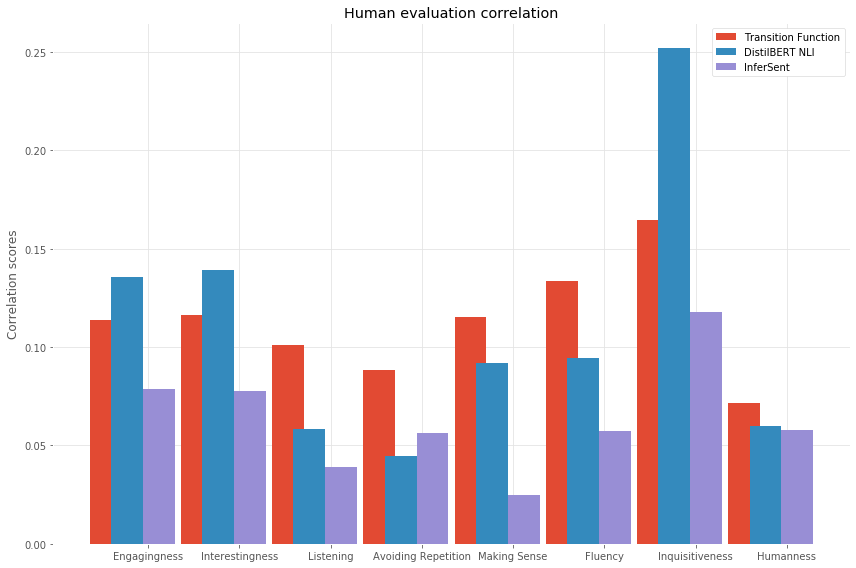

In [323]:
mode = 'spearman'
draw_bar([
    get_scores(conv_dial_scores, 'score_0',mode),
    get_scores(conv_dial_scores, 'bertnli_all_score_0',mode),
    get_scores(conv_dial_scores, 'infersent_all_score_0',mode),
],[
    'Transition Function',
    'DistilBERT NLI',
    'InferSent'
])

[-0.46666667  0.53333333  1.53333333  2.53333333  3.53333333  4.53333333
  5.53333333  6.53333333]
[-0.23333333  0.76666667  1.76666667  2.76666667  3.76666667  4.76666667
  5.76666667  6.76666667]
[0.11666667 1.11666667 2.11666667 3.11666667 4.11666667 5.11666667
 6.11666667 7.11666667]


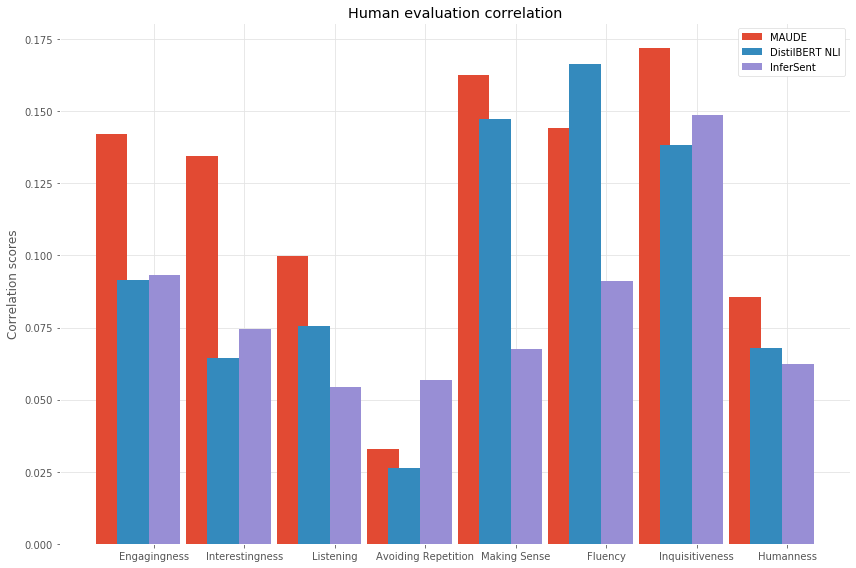

In [336]:
mode = 'spearman'
draw_bar([
    get_scores(conv_dial_scores, 'na_all_score_20488119',mode),
    get_scores(conv_dial_scores, 'bertnli_all_score_20497378',mode),
    get_scores(conv_dial_scores, 'infersent_all_score_20495233',mode),
],[
    'MAUDE',
    'DistilBERT NLI',
    'InferSent'
])

In [546]:
hum_c_data = {'score':[],'metric':[],'model':[]}

models = {'na_all_score_20488119':'MAUDE','bertnli_all_score_20497378':'DistilBERT-NLI',
          'infersent_all_score_20495233':'InferSent','ruber_all_score_20688482':'RUBER'}
#models = {'na_all_score_20488119':'MAUDE','bertnli_all_score_20497378':'DistilBERT-NLI','infersent_all_score_20495233':'InferSent',
#          'na_all_context_score_20488123':'MAUDE_Context'}
for md,model_name in models.items():
    sc = get_scores(conv_dial_scores, md ,mode)
    for si in sc:
        hum_c_data['score'].append(si[1])
        hum_c_data['metric'].append(nice_metric_names[si[0]])
        hum_c_data['model'].append(model_name)

In [547]:
hum_c_df = pd.DataFrame(hum_c_data)

In [548]:
hum_c_df.columns = ['Correlation','Metric','Model']

In [549]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

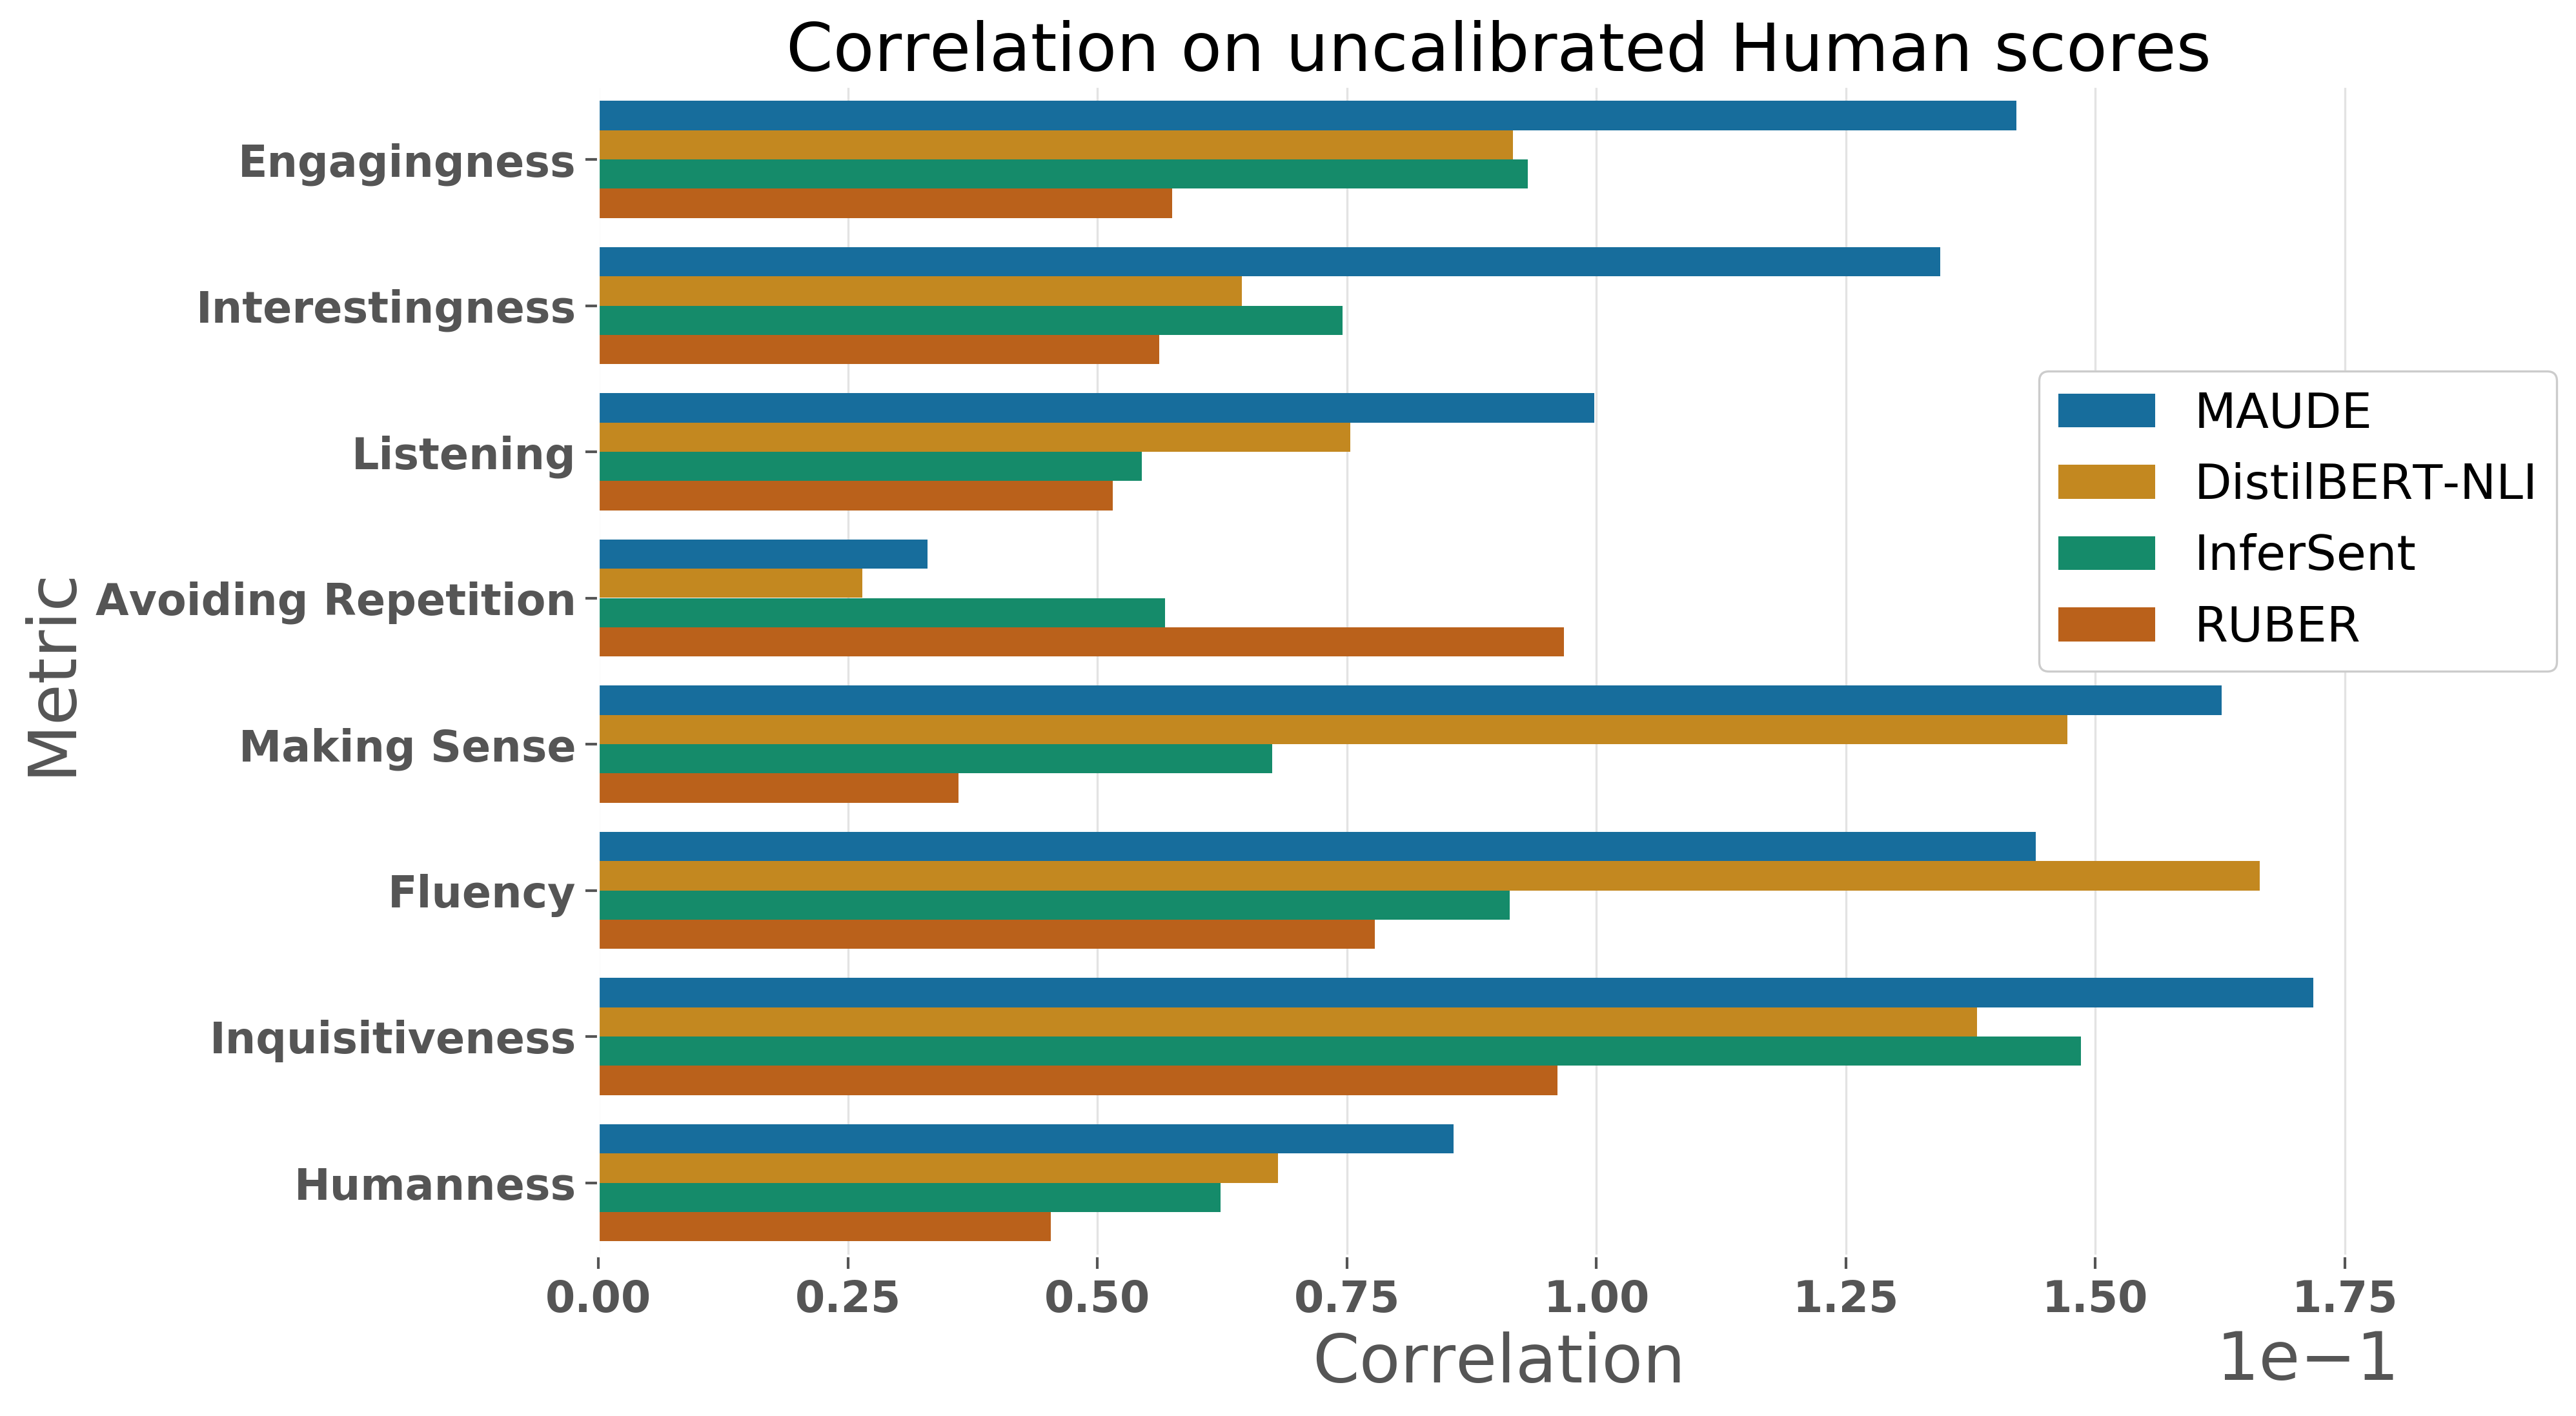

In [555]:
sns.set_context("paper")
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(16)
    label.set_fontweight('semibold')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,10))
ax.xaxis.get_offset_text().set_fontsize(25)
axis_font = {'fontname':'Arial', 'size':'25'}
bar = sns.barplot(x="Correlation", y="Metric", hue="Model", data=hum_c_df,
                palette="colorblind")
# hatches = ['\\', '*', 'o']
# hi = 0
# for i,thisbar in enumerate(bar.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[hi])
#     hi +=1
#     if hi == len(hatches):
#         hi = 0
ax.legend(loc=(0.8, 0.5), prop={'size' : 18})
ax.set_xlabel('Correlation',**axis_font)
ax.set_ylabel('Metric', **axis_font)
ax.set_title('Correlation on uncalibrated Human scores', **axis_font)
plt.savefig('/private/home/koustuvs/mlp/latentDialogAnalysis/plot.png', bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [333]:
conv_dial_scores.columns

Index(['model_name', 'model_type', 'model_bucket', 'dialog',
       'assignment_id_hashed', 'evaluator_id_hashed', 'enjoy', 'interest',
       'listen', 'turing', 'avoid_rep', 'make_sense', 'fluency',
       'persona_guess', 'inquisitive', 'Unnamed: 0', 'Unnamed: 0.1',
       'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'Unnamed: 0.1.1.1.1',
       'Unnamed: 0.1.1.1.1.1', 'Unnamed: 0.1.1.1.1.1.1',
       'Unnamed: 0.1.1.1.1.1.1.1', 'Unnamed: 0.1.1.1.1.1.1.1.1',
       'Unnamed: 0.1.1.1.1.1.1.1.1.1', 'score_19334597', 'score_20330191',
       'score_20391351', 'score_0', 'bertnli_all_score_0',
       'infersent_all_score_0', 'infersent_all_score_20495233',
       'bertnli_all_score_20497378', 'na_all_score_20488119'],
      dtype='object')

In [227]:
np.mean(scores)

0.1189732718251231

In [338]:
from scipy.stats import pearsonr, spearmanr

In [ ]:
pearsonr()

In [228]:
scores = []
for mtype in test_types:
    print(mtype,conv_dial_scores[mtype].corr(conv_dial_scores.bertnli_all_score_0, method='spearman'))
    scores.append(conv_dial_scores[mtype].corr(conv_dial_scores., method='spearman'))

enjoy 0.13580481995467283
interest 0.1393006585563305
listen 0.05838597820259068
avoid_rep 0.04480158539628829
make_sense 0.09177380472560527
fluency 0.09450006095820263
inquisitive 0.2519755116232191


In [229]:
np.mean(scores)

0.11664891705955846

In [237]:
scores = []
for mtype in test_types:
    print(mtype,conv_dial_scores[mtype].corr(conv_dial_scores.infersent_all_score_0, method='spearman'))
    scores.append(conv_dial_scores[mtype].corr(conv_dial_scores.infersent_all_score_0, method='spearman'))

enjoy 0.07868559748363084
interest 0.07793339558703702
listen 0.03928137487904862
avoid_rep 0.0564992209425539
make_sense 0.024904306313232687
fluency 0.05728998164309008
inquisitive 0.11793755549446987


In [238]:
np.mean(scores)

0.06464734747758043

In [201]:
for mtype in ['enjoy','interest','listen','turing','avoid_rep','make_sense','fluency','persona_guess','inquisitive']:
    print(mtype,conv_dial_scores[mtype].corr(conv_dial_scores.score_0, method='pearson'))

enjoy 0.1516993625885021
interest 0.14551864598229122
listen 0.161296287333335
turing 0.08362231919692306
avoid_rep 0.10642082574249448
make_sense 0.18540068709932822
fluency 0.22530555577718
persona_guess 0.04767130436690969
inquisitive 0.2028516420469267


In [212]:
for mtype in ['enjoy','interest','listen','turing','avoid_rep','make_sense','fluency','persona_guess','inquisitive']:
    print(mtype,conv_dial_scores[mtype].corr(conv_dial_scores.bertnli_all_score_0, method='pearson'))

enjoy 0.16796941589470038
interest 0.16409827496710805
listen 0.12098318882941125
turing 0.08243756457595186
avoid_rep 0.09426008377325819
make_sense 0.14570389385985527
fluency 0.18655619203437482
persona_guess -0.04772318971855941
inquisitive 0.28793018069171794


## Exploring the prediction of our model

### Best predictions

In [556]:
## best score
conv_dial_scores.na_all_score_20488119.argmax()

/private/home/koustuvs/miniconda3/envs/dialog/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  


2237

In [588]:
nice_metric_names

{'enjoy': 'Engagingness',
 'interest': 'Interestingness',
 'inquisitive': 'Inquisitiveness',
 'listen': 'Listening',
 'avoid_rep': 'Avoiding Repetition',
 'fluency': 'Fluency',
 'make_sense': 'Making Sense',
 'turing': 'Humanness',
 'persona_guess': 'Persona retrieval'}

In [594]:
def print_nice_scores(loc):
    tr = ""
    for nice_m,good_m in nice_metric_names.items():
        tr += "{} : {}, ".format(good_m, loc[nice_m])
    print(tr)

In [595]:
print_nice_scores(conv_dial_scores.loc[2237])

Engagingness : 3, Interestingness : 3, Inquisitiveness : 2, Listening : 3, Avoiding Repetition : 3, Fluency : 4, Making Sense : 4, Humanness : 3, Persona retrieval : 1, 


In [557]:
conv_dial_scores.loc[2237]

model_name                                  interesting_nidf_model_ct_setting7                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
model_type                                  nidf_ct                                                                                                    

In [110]:
pd.set_option('display.max_colwidth', -1)

In [569]:
raw_scores[raw_scores.assignment_id_hashed == 'dc89b4e7bb30d3239206500a71b97600d0fe24c4'][models.keys()]

,na_all_score_20488119,bertnli_all_score_20497378,infersent_all_score_20495233,ruber_all_score_20688482
12353,1.0000,0.9980,0.9082,0.9432
12354,0.9973,0.9932,0.3007,0.3339
12355,0.9981,0.9819,0.5930,0.4648
12356,0.9984,0.9565,0.5913,0.4327
12357,0.9991,0.9808,0.2841,0.2475
12358,0.9950,0.9576,0.7330,0.5420


In [558]:
render_conversation(conv_dial_scores.iloc[2237], raw_scores)

### Worst Scores

In [561]:
## worst scores

conv_dial_scores.na_all_score_20488119.argmin()

/private/home/koustuvs/miniconda3/envs/dialog/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


2158

In [105]:
conv_dial_scores.score_19334597.min()

0.0021781351781100964

In [563]:
conv_dial_scores.loc[2158]

model_name                                  interesting_nidf_model_bfw_setting_08                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [108]:
conv_dial_scores.loc[319]['dialog']

[{'speaker': 'model', 'text': 'Hi how are you today'},
 {'speaker': 'human_evaluator',
  'text': 'I am good. Its quiet in the rural farming community where I live. Where are you from?'},
 {'speaker': 'model', 'text': 'I am from the united states'},
 {'speaker': 'human_evaluator', 'text': 'Do you have any family?'},
 {'speaker': 'model', 'text': "No I don't do you"},
 {'speaker': 'human_evaluator', 'text': 'I have a husband. Hes adopted.'},
 {'speaker': 'model', 'text': "I'm sorry to hear that"},
 {'speaker': 'human_evaluator',
  'text': 'Do you watch any sports? I like NHL.'},
 {'speaker': 'model', 'text': 'I do not like sports'},
 {'speaker': 'human_evaluator', 'text': 'what do you do for a living'},
 {'speaker': 'model', 'text': 'I work as a chef'},
 {'speaker': 'human_evaluator', 'text': 'What is your favorite food?'}]

In [567]:
raw_scores[raw_scores.assignment_id_hashed == '7641412aa7c2936c8565661c0d945122eceafb97'].reset_index()

,index,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1,context,response,assignment_id_hashed,evaluator_id_hashed,score_19334597,score_20330191,score_20391351,score_0,bertnli_all_score_0,infersent_all_score_0,infersent_all_score_20495233,bertnli_all_score_20497378,na_all_score_20488119,na_all_context_score_20488122,na_all_context_score_20488123,ruber_all_score_20688482
0,11922,11922,11922,11922,11922,11922,11922,11922,11922,11922,11922,11922,11922,11922,11922,11922,11922,"hi names jace and i drive a stickshift f150\nhi, my name's carroll and i drive a mini van. haha",hondas kawasaki acura passa sx bu hace rrrr hui bien hao,7641412aa7c2936c8565661c0d945122eceafb97,3f03823334bf91fbe9873a340dc47e6806f335f8,0.1742,0.5594,0.7462,0.2990,0.2747,0.4072,0.2106,0.5986,0.0366,0.0149,0.1376,0.4273
1,11923,11923,11923,11923,11923,11923,11923,11923,11923,11923,11923,11923,11923,11923,11923,11923,11923,"hi names jace and i drive a stickshift f150\nhi, my name's carroll and i drive a mini van. haha\nhondas kawasaki acura passa sx bu hace rrrr hui bien hao\ni'm sorry, what?",ll pinche peu pasa sya bla woh numa asi paino gila fer heaven's sake eh buh tsk dun wah arf whoo doo deh pon di kina dum dippy p,7641412aa7c2936c8565661c0d945122eceafb97,3f03823334bf91fbe9873a340dc47e6806f335f8,0.3325,0.0009,0.0825,0.0070,0.0340,0.4939,0.6073,0.0002,0.0000,0.0000,0.0001,0.5737
2,11924,11924,11924,11924,11924,11924,11924,11924,11924,11924,11924,11924,11924,11924,11924,11924,11924,"hi names jace and i drive a stickshift f150\nhi, my name's carroll and i drive a mini van. haha\nhondas kawasaki acura passa sx bu hace rrrr hui bien hao\ni'm sorry, what?\nll pinche peu pasa sya bla woh numa asi paino gila fer heaven's sake eh buh tsk dun wah arf whoo doo deh pon di kina dum dippy p\ni don't understand..",wher arre dey loke da fuc dah ni mach zu guan adrenalin howls ain ju ching wei oui kora maye zi goti ta creat vera,7641412aa7c2936c8565661c0d945122eceafb97,3f03823334bf91fbe9873a340dc47e6806f335f8,0.5926,0.1831,0.4986,0.0393,0.0411,0.4933,0.7568,0.0752,0.0001,0.0001,0.0280,0.6388
3,11925,11925,11925,11925,11925,11925,11925,11925,11925,11925,11925,11925,11925,11925,11925,11925,11925,"hi names jace and i drive a stickshift f150\nhi, my name's carroll and i drive a mini van. haha\nhondas kawasaki acura passa sx bu hace rrrr hui bien hao\ni'm sorry, what?\nll pinche peu pasa sya bla woh numa asi paino gila fer heaven's sake eh buh tsk dun wah arf whoo doo deh pon di kina dum dippy p\ni don't understand..\nwher arre dey loke da fuc dah ni mach zu guan adrenalin howls ain ju ching wei oui kora maye zi goti ta creat vera\nwhat on earth are you talking about?",yo gotti isn'thing tu ruff boosie dontcha fet thos fishy beetles killa fien mus slurp the&gt mater ke maximo estas esta aking cayden tobe hur,7641412aa7c2936c8565661c0d945122eceafb97,3f03823334bf91fbe9873a340dc47e6806f335f8,0.0619,0.0016,0.0948,0.0028,0.0049,0.4494,0.6635,0.0028,0.0000,0.0000,0.0094,0.7307
4,11926,11926,11926,11926,11926,11926,11926,11926,11926,11926,11926,11926,11926,11926,11926,11926,11926,"hi names jace and i drive a stickshift f150\nhi, my name's carroll and i drive a mini van. haha\nhondas kawasaki acura passa sx bu hace rrrr hui bien hao\ni'm sorry, what?\nll pinche peu pasa sya bla woh numa asi paino gila fer heaven's sake eh buh tsk dun wah arf whoo doo deh pon di kina dum dippy p\ni don't understand..\nwher arre dey loke da fuc dah ni mach zu guan adrenalin howls ain ju ching wei oui kora maye zi goti ta creat vera\nwhat on earth are you talking about?\nyo gotti isn'thing tu ruff boosie dontcha fet thos fishy beetles killa fien 

In [570]:
raw_scores[raw_scores.assignment_id_hashed == '7641412aa7c2936c8565661c0d945122eceafb97'][models.keys()]

,na_all_score_20488119,bertnli_all_score_20497378,infersent_all_score_20495233,ruber_all_score_20688482
11922,0.0366,0.5986,0.2106,0.4273
11923,0.0000,0.0002,0.6073,0.5737
11924,0.0001,0.0752,0.7568,0.6388
11925,0.0000,0.0028,0.6635,0.7307
11926,0.0002,0.0002,0.5358,0.6433


In [596]:
print_nice_scores(conv_dial_scores.iloc[2158])

Engagingness : 1, Interestingness : 4, Inquisitiveness : 1, Listening : 1, Avoiding Repetition : 3, Fluency : 1, Making Sense : 2, Humanness : 1, Persona retrieval : 1, 


In [562]:
render_conversation(conv_dial_scores.iloc[2158])

## Failure case - engagiment = 1 but Maude score > 0.9

In [576]:
failure_cases = conv_dial_scores[(conv_dial_scores.na_all_score_20488119 > 0.9) & (conv_dial_scores.interest == 1)]
len(failure_cases)

171

In [577]:
len(failure_cases) / len(conv_dial_scores)

0.051568154402895056

In [585]:
conv_dial_scores.iloc[1113]['assignment_id_hashed']

'32f3e1b98de27cd064b1a9e11c43e375136a3ee2'

In [584]:
# failure_cases.sample(1) # - 1113
render_conversation(conv_dial_scores.iloc[1113])

In [586]:
raw_scores[raw_scores.assignment_id_hashed == '32f3e1b98de27cd064b1a9e11c43e375136a3ee2'][models.keys()]

,na_all_score_20488119,bertnli_all_score_20497378,infersent_all_score_20495233,ruber_all_score_20688482
6148,0.9984,0.9521,0.7863,0.7235
6149,0.9331,0.9595,0.4120,0.1187
6150,0.7382,0.9505,0.0048,0.0029
6151,0.9955,0.9798,0.2685,0.4402
6152,0.9942,0.9789,0.0796,0.0142
6153,0.9917,0.9808,0.0115,0.0066


In [599]:
nice_metric_names

{'enjoy': 'Engagingness',
 'interest': 'Interestingness',
 'inquisitive': 'Inquisitiveness',
 'listen': 'Listening',
 'avoid_rep': 'Avoiding Repetition',
 'fluency': 'Fluency',
 'make_sense': 'Making Sense',
 'turing': 'Humanness',
 'persona_guess': 'Persona retrieval'}

In [597]:
print_nice_scores(conv_dial_scores.iloc[1953])

Engagingness : 1, Interestingness : 1, Inquisitiveness : 2, Listening : 2, Avoiding Repetition : 2, Fluency : 3, Making Sense : 4, Humanness : 2, Persona retrieval : 1, 


In [582]:
conv_dial_scores.iloc[1953]

model_name                                  repetition_model_settinginf                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
model_type                                  repetition-bfw                             

In [ ]:
conv_dial_scores

In [571]:
conv_dial_scores.columns

Index(['model_name', 'model_type', 'model_bucket', 'dialog',
       'assignment_id_hashed', 'evaluator_id_hashed', 'enjoy', 'interest',
       'listen', 'turing', 'avoid_rep', 'make_sense', 'fluency',
       'persona_guess', 'inquisitive', 'Unnamed: 0', 'Unnamed: 0.1',
       'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'Unnamed: 0.1.1.1.1',
       'Unnamed: 0.1.1.1.1.1', 'Unnamed: 0.1.1.1.1.1.1',
       'Unnamed: 0.1.1.1.1.1.1.1', 'Unnamed: 0.1.1.1.1.1.1.1.1',
       'Unnamed: 0.1.1.1.1.1.1.1.1.1', 'Unnamed: 0.1.1.1.1.1.1.1.1.1.1',
       'Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1',
       'Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1',
       'Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1',
       'Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1',
       'Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1', 'score_19334597',
       'score_20330191', 'score_20391351', 'score_0', 'bertnli_all_score_0',
       'infersent_all_score_0', 'infersent_all_score_20495233',
       'bertnli_all_score_20497378', 'na_all_score_20488119',
       'na_a

## Which type of model has best scores

In [600]:
conv_dial_scores.groupby(['model_name']).mean()

,enjoy,interest,listen,turing,avoid_rep,make_sense,fluency,persona_guess,inquisitive,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1,score_19334597,score_20330191,score_20391351,score_0,bertnli_all_score_0,infersent_all_score_0,infersent_all_score_20495233,bertnli_all_score_20497378,na_all_score_20488119,na_all_context_score_20488122,na_all_context_score_20488123,ruber_all_score_20688482
model_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
baseline_model,2.3514,2.3514,2.6306,1.8108,2.1441,3.3964,3.2252,0.7748,2.4955,"10,059.7027","10,059.7027","10,059.7027","10,059.7027","10,059.7027","10,059.7027","10,059.7027","10,059.7027","10,059.7027","10,059.7027","10,059.7027","10,059.7027","10,059.7027","10,059.7027","10,059.7027","10,059.7027",0.3397,0.6752,0.9256,0.7276,0.5871,0.3746,0.5070,0.9538,0.9333,0.8270,0.9493,0.4218
greedy_model,2.3060,2.3582,2.7836,1.7836,2.1567,3.3284,3.2015,0.8657,2.0000,"8,940.7761","8,940.7761","8,940.7761","8,940.7761","8,940.7761","8,940.7761","8,940.7761","8,940.7761","8,940.7761","8,940.7761","8,940.7761","8,940.7761","8,940.7761","8,940.7761","8,940.7761","8,940.7761",0.2846,0.4651,0.8722,0.6558,0.4702,0.2367,0.3029,0.8436,0.8137,0.7827,0.8247,0.2831
human_eval,3.3137,3.2255,3.6373,3.4020,2.9020,3.8431,3.6569,0.9216,2.6275,"9,042.4657","9,042.4657","9,042.4657","9,042.4657","9,042.4657","9,042.4657","9,042.4657","9,042.4657","9,042.4657","9,042.4657","9,042.4657","9,042.4657","9,042.4657","9,042.4657","9,042.4657","9,042.4657",0.5341,0.6911,0.9016,0.7214,0.5899,0.3917,0.4001,0.8586,0.8537,0.7621,0.8002,0.3743
inquisitive_model_ct_setting00,2.9159,2.8505,3.2897,2.4860,2.9533,3.5607,3.7009,0.8598,2.4766,"8,314.2991","8,314.2991","8,314.2991","8,314.2991","8,314.2991","8,314.2991","8,314.2991","8,314.2991","8,314.2991","8,314.2991","8,314.2991","8,314.2991","8,314.2991","8,314.2991","8,314.2991","8,314.2991",0.2962,0.6326,0.9057,0.6961,0.5457,0.3578,0.4545,0.9323,0.9026,0.8217,0.9323,0.4371
inquisitive_model_ct_setting01,2.9355,2.8548,3.3226,2.4677,2.8790,3.6290,3.5887,0.8468,2.5161,"8,992.1935","8,992.1935","8,992.1935","8,992.1935","8,992.1935","8,992.1935","8,992.1935","8,992.1935","8,992.1935","8,992.1935","8,992.1935","8,992.1935","8,992.1935","8,992.1935","8,992.1935","8,992.1935",0.2730,0.6640,0.9131,0.6984,0.5660,0.3605,0.4450,0.9347,0.9137,0.8223,0.9337,0.4258
inquisitive_model_ct_setting04,2.8839,2.8214,3.3661,2.4196,2.8750,3.6339,3.5893,0.8393,2.5536,"9,269.9464","9,269.9464","9,269.9464","9,269.9464","9,269.9464","9,269.9464","9,269.9464","9,269.9464","9,269.9464","9,269.9464","9,269.9464","9,269.9464","9,269.9464","9,269.9464","9,269.9464","9,269.9464",0.3918,0.6529,0.9258,0.7451,0.6142,0.3805,0.4643,0.9343,0.9008,0.8159,0.9196,0.4350
inquisitive_model_ct_setting07,3.0704,2.9718,3.2254,2.4225,2.8803,3.5282,3.6690,0.8028,2.7465,"9,082.3627","9,082.3627","9,082.3627","9,082.3627","9,082.3627","9,082.3627","9,082.3627","9,082.3627","9,082.3627","9,082.3627","9,082.3627","9,082.3627","9,082.3627","9,082.3627","9,082.3627","9,082.3627",0.4098,0.7117,0.9360,0.7538,0.6331,0.3941,0.4997,0.9489,0.9319,0.8282,0.9461,0.4524
inquisitive_model_ct_setting10,2.9048,2.7238,3.1238,2.4286,2.7429,3.5905,3.6952,0.7905,2.7143,"9,366.2429","9,366.2429","9,366.2429","9,366.2429","9,366.2429","9,366.2429","9,366.2429","9,366.2429","9,366.2429","9,366.2429","9,366.2429","9,366.2429","9,366.2429","9,366.2429","9,366.2429","9,366.2429",0.4756,0.7424,0.9445,0.7756,0.6514,0.4273,0.5485,0.9507,0.9415,0.8375,0.9540,0.4807
inquisitive_model_ct_setting10_better,2.8440,2.8257,3.1835,2.2569,2.7615,3.5229,3.5963,0.7156,2.9358,"9,230.5367","9,230.5367","9,230.5367","9,

### How does the human annotation scores look

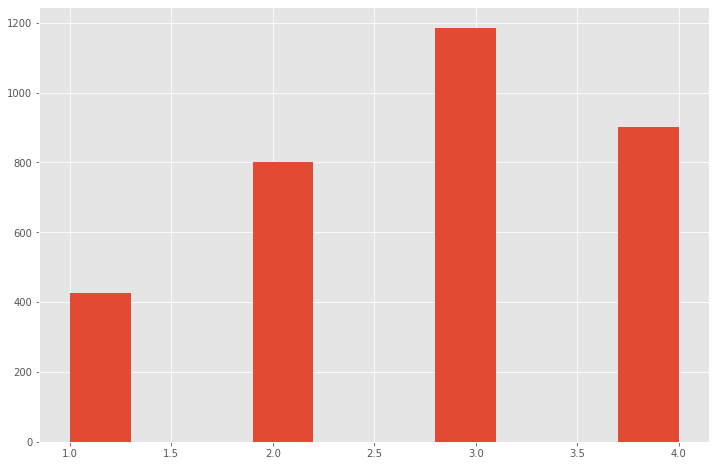

In [121]:
conv_dial_scores.enjoy.hist()

### How does each model score distribution look?

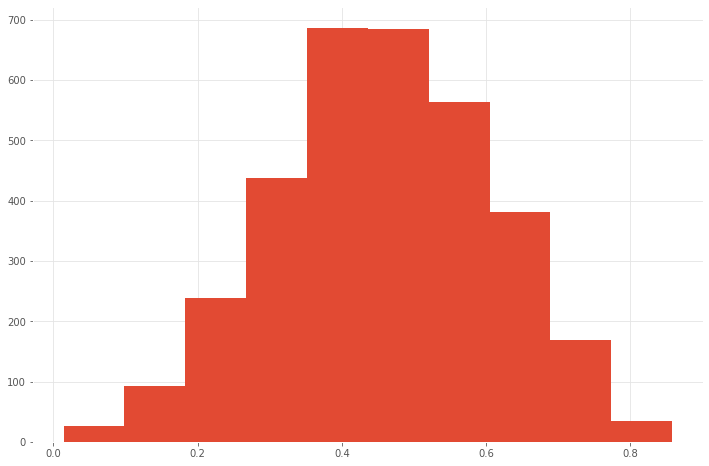

In [330]:
conv_dial_scores.infersent_all_score_20495233.hist()

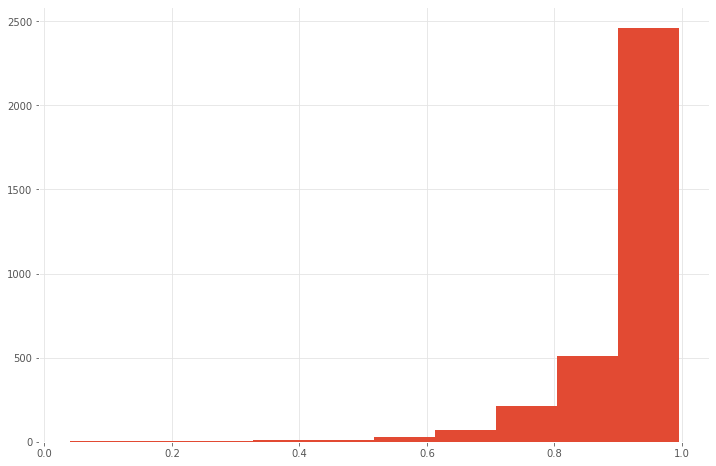

In [331]:
conv_dial_scores.bertnli_all_score_20497378.hist()

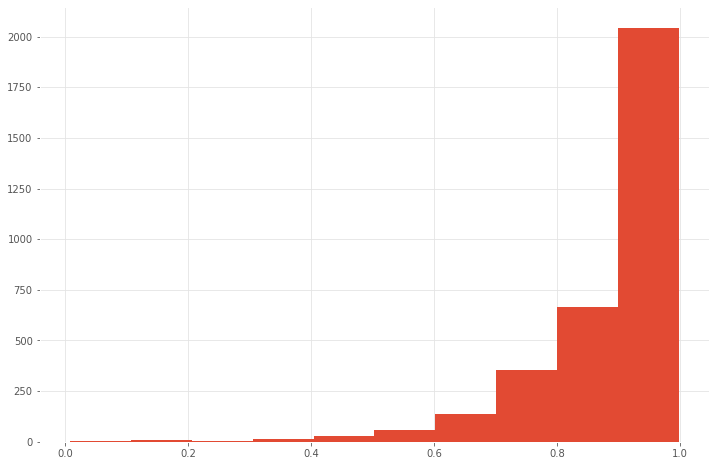

In [332]:
conv_dial_scores.na_all_score_20488119.hist()

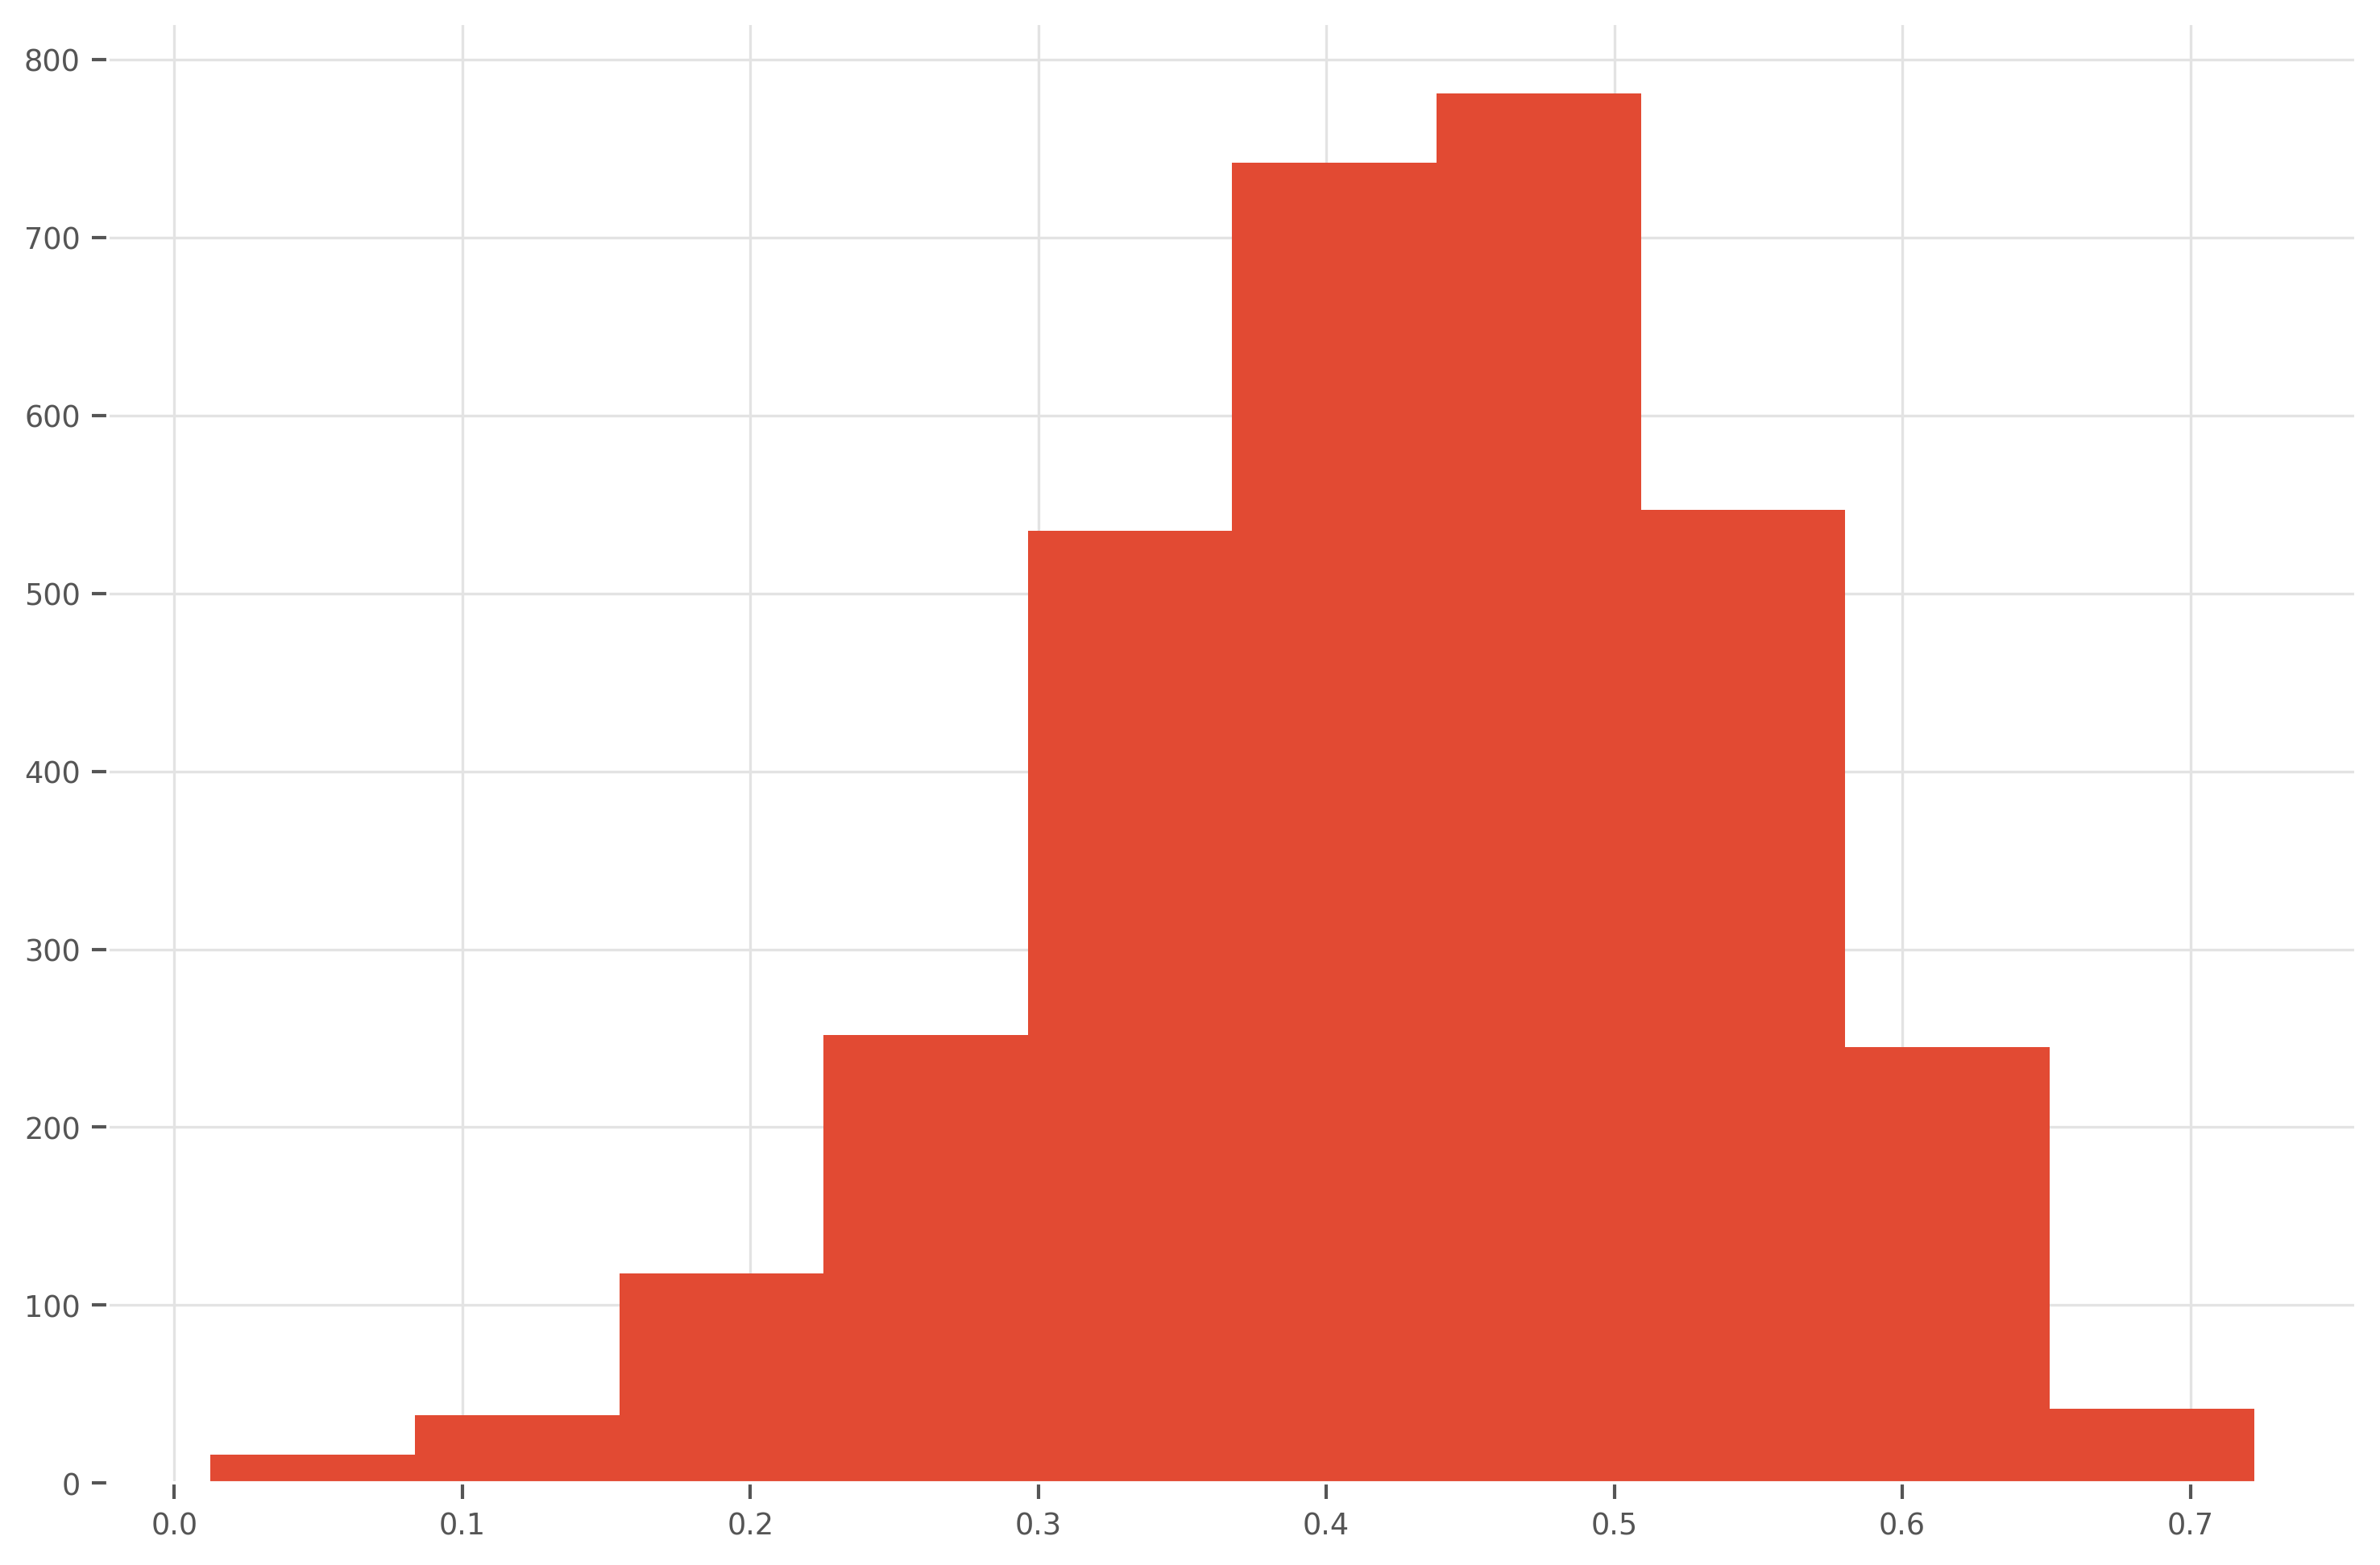

In [601]:
conv_dial_scores.ruber_all_score_20688482.hist()

In [16]:
conversation_table.head()

,model_name,model_type,model_bucket,dialog,assignment_id_hashed,evaluator_id_hashed,enjoy,interest,listen,turing,avoid_rep,make_sense,fluency,persona_guess,inquisitive
768,greedy_model,greedy,,"[{'speaker': 'human_evaluator', 'text': 'Hello...",a706730a6ee7880a2a0a3ec996c9d2a5aa869edd,ed4672327c64575a1be57fe0917cfc49c0d948c0,2,3,3,2,2,4,3,1,2
2897,inquisitive_model_ct_setting10_better,inquisitive-ct,011,"[{'speaker': 'human_evaluator', 'text': 'hi th...",970eafa6cb745ff152115946d1787c63d9db2c35,36b72818d076742ba2dffb0dbec91e657917af42,3,3,3,3,3,4,4,1,2
1870,repetition_model_setting35,repetition-bfw,2gram=035,"[{'speaker': 'model', 'text': 'Hi how are you ...",13f2a54504ec8d8474301e6b406e30000564aba2,d8f9fe2b338c05ce8e9ed30478ef09d1fa693c62,4,4,4,4,3,4,4,1,3
1613,inquisitive_model_ct_setting07,inquisitive-ct,007,"[{'speaker': 'model', 'text': 'How are you doi...",c556893edf878c4d280370463fce760357a5ffb9,9b6c716b0a858f39e63c50206326eb74e8025615,4,4,3,2,3,4,4,1,3
2269,interesting_nidf_model_ct_setting7,nidf_ct,007,"[{'speaker': 'model', 'text': 'Hi how ar you d...",7e6088da279a5251111f57a2fa0b9df37b0f5aac,660210871d7f34227c595b02363f4c1aee99cece,4,3,3,4,3,4,3,1,1


In [173]:
conversation_table.groupby(["model_type", "model_bucket"]).mean()

enjoy  interest  listen  turing  avoid_rep  \
model_type     model_bucket                                                     
baseline                          2.3514 2.3514    2.6306  1.8108  2.1441       
greedy                            2.3060 2.3582    2.7836  1.7836  2.1567       
human                             3.3137 3.2255    3.6373  3.4020  2.9020       
inquisitive-ct 000                2.9159 2.8505    3.2897  2.4860  2.9533       
               001                2.9355 2.8548    3.3226  2.4677  2.8790       
               004                2.8839 2.8214    3.3661  2.4196  2.8750       
               007                3.0704 2.9718    3.2254  2.4225  2.8803       
               010                2.9048 2.7238    3.1238  2.4286  2.7429       
               011                2.8440 2.8257    3.1835  2.2569  2.7615       
nidf_bfw       -04                2.7805 2.6423    3.2846  2.4065  2.9024       
               -10                2.4322 2.3814    3.0339  2.1525  2.8475       
               004                2.9904 3.0000    3.3654  2.4904  2.9519       
               006                2.9633 3.0550    3.2385  2.4128  2.9266       
               008                2.4000 2.5500    2.6083  1.8583  2.7833       
nidf_ct        000                2.9623 2.8585    3.2925  2.4151  2.8302       
               002                2.7759 2.8017    3.1379  2.3707  2.8966       
               004                2.8100 2.8000    3.2500  2.3400  2.9200       
               007                3.0000 2.9048    3.3429  2.5333  2.8857       
               009                2.8304 2.8393    3.0714  2.4018  2.9018       
repetition-bfw 2gram=005          2.5583 2.6083    3.0833  2.1917  2.6583       
               2gram=012          2.9083 2.8624    3.2110  2.3211  2.8440       
               2gram=035          2.9504 2.8760    3.2727  2.4463  2.9008       
               2gram=035 stop=inf 2.8938 2.9646    3.2478  2.5044  2.8938       
               2gram=999          2.9587 2.8595    3.3058  2.4050  2.8182       
responsive     -10                2.4790 2.5294    2.8403  2.0168  2.8571       
               000                3.0088 2.9204    3.3717  2.7257  2.9646       
               005                2.8818 2.8545    3.2727  2.4091  2.9000       
               010                2.3879 2.5690    3.0259  1.9655  2.7845       
               013                2.1043 2.3304    2.6870  1.8087  2.7130       

                                   make_sense  fluency  persona_guess  \
model_type     model_bucket                                             
baseline                          3.3964      3.2252   0.7748           
greedy                            3.3284      3.2015   0.8657           
human                             3.8431      3.6569   0.9216           
inquisitive-ct 000                3.5607      3.7009   0.8598           
               001                3.6290      3.5887   0.8468           
               004                3.6339      3.5893   0.8393           
               007                3.5282      3.6690   0.8028           
               010                3.5905      3.6952   0.7905           
               011                3.5229      3.5963   0.7156           
nidf_bfw       -04                3.5610      3.5528   0.8211           
               -10                3.3305      3.3390   0.7119           
               004                3.6346      3.6538   0.9327           
               006                3.4954      3.5229   0.9266           
               008                2.9083      2.6750   0.9167           
nidf_ct        000                3.6604      3.6226   0.7170           
               002                3.5000      3.6034   0.8103           
               004                3.5000      3.6500   0.8600           
               007                3.5905      3.6381   0.8190           
               009                3.5804      3.6071   0.8839  

### Bayesian calibration helpers

In [500]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12.0, 8.0]

plt.rcParams['axes.facecolor'] = '#FFFFFF'
plt.rcParams['grid.color'] = '#E3E3E3'
plt.rcParams['legend.framealpha'] = 1.0
plt.rcParams['axes.labelweight'] = 'normal'

MAIN_COLOR = 'k'

CM = 0.393700787

SOLO_FIG_SIZE = (16 * CM, CM * 16 * 0.5)

nice_names = {
    'repetition++': 'Repetition-controlled baseline+',
    'baseline_model': 'Beam search baseline',
    'inquisitive-ct': 'Question-controlled CT',
    'human_eval': 'Human',
    'repetition_model_setting35_settinginf': 'Repetition-controlled baseline',
    'nidf_ct': 'Specificity-controlled CT',
    'nidf_bfw': 'Specificity-controlled WD',
    'responsive': 'Response-related controlled WD',
    'greedy_model': 'Greedy search baseline',
    'repetition_model_setting05': 'Extrep\nbigram -0.5',
    'repetition_model_setting12': 'Extrep\nbigram -1.25',
    'repetition_model_setting35': 'Extrep\nbigram -3.5',
    'repetition_model_settinginf': 'Extrep\nbigram -inf',
}

nice_names_rep = {
    **nice_names,

    'repetition_model_setting35_settinginf': 'Extrep bigram -3.5\n+ unigram -inf',
    'repetition++': '+ Partner\nIntrep bigram',

}

nice_colors = {
    'repetition_model_setting35_settinginf': 'C2',
    'repetition++': 'C2',
    'human_eval': '#d89a2f',
    'baseline_model': 'C1',
    'greedy_model': 'C5',
    'inquisitive_model_ct_setting07': 'C3',
    'interesting_nidf_model_bfw_setting_04': 'C6',
}
nice_styles = {
    'repetition_model_setting35_settinginf': '--',
    'repetition++': '--',
    'human_eval': '-.',
    'baseline_model': ':',
    'greedy_model': '--',
}
nice_metric_names = {
    'enjoy': 'Engagingness',
    'interest': 'Interestingness',
    'inquisitive': 'Inquisitiveness',
    'listen': 'Listening',
    'avoid_rep': 'Avoiding Repetition',
    'fluency': 'Fluency',
    'make_sense': 'Making Sense',
    'turing': 'Humanness', 
    'persona_guess': 'Persona retrieval',
}

In [501]:
LIKERT_METRICS = ['fluency', 'enjoy', 'turing', 'make_sense', 'inquisitive', 'interest', 'avoid_rep', 'listen']
def modelname_subset(data, model_keys):
    return data[data.model_name.apply(lambda x: x in model_keys)]

def modeltype_subset(data, model_keys):
    return data[data.model_type.apply(lambda x: x in model_keys)].sort_values(['model_type', 'model_bucket'])

import os
HOME = os.environ['HOME']
try:
    os.mkdir(HOME + '/plots')
except IOError:
    pass

Output latex for the raw scores table

In [502]:
results_raw = conversation_table.copy().groupby(['model_name', 'model_type', 'model_bucket']).aggregate({
    k: [np.mean, np.std]
    for k in LIKERT_METRICS + ['persona_guess']
}).reset_index()
results_raw.columns = ['_'.join([c for c in col if c.strip()]) for col in results_raw.columns.values]
results_raw = results_raw.set_index('model_name')

# nice_raw = []
# colmax = results_raw[results_raw.index != 'human_eval'].max(axis=0)
# for model_name, row in results_raw.iterrows():
#     x = {}
#     for m in LIKERT_METRICS + ['persona_guess']:
#         val = '{:.2f} $\\pm$ {:.2f}'.format(row[m + '_mean'], row[m + '_std'])
#         if row[m + '_mean'] == colmax[m + '_mean']:
#             val = '{\\bf ' + val + '}'
#         x[nice_metric_names[m]] = val
#     x['model_name'] = nice_names.get(
#         model_name,
#         nice_names.get(
#             row['model_type'],
#             row['model_type']
#         ) + ' ' + str(row['model_bucket'])
#     )
#     nice_raw.append(x)

# nice_raw = pd.DataFrame(nice_raw).set_index('model_name')
# print(nice_raw.to_latex(escape=False))

In [519]:
results_bayes.index = results_bayes.index.str.strip()
# things that have two names
results_bayes.loc['repetition++'] = results_bayes.loc['responsiveness_model_bfw_setting_00']
results_bayes.loc['repetition++','model_type'] = 'repetition-bfw'

results_bayes.loc['interesting_nidf_model_bfw_setting_00'] = results_bayes.loc['repetition_model_setting35_settinginf']
results_bayes.loc['interesting_nidf_model_bfw_setting_00','model_type'] = 'nidf_bfw'
results_bayes.loc['interesting_nidf_model_bfw_setting_00','model_bucket'] = '00'

results_bayes.loc['inquisitive_model_ct_setting10_better', 'model_bucket'] = '12'

# prep results
altered = results_bayes.copy().reset_index()
altered["model_bucket"] = altered.model_bucket.astype('category')

In [363]:
altered['fluency_mean'].corr(altered['na_all'], method='spearman')

0.31625655506252526

In [137]:
nice_bayes = []
colmax = results_bayes[results_bayes.index != 'human_eval'].max(axis=0)
for model_name, row in results_bayes.iterrows():
    x = {}
    for m in LIKERT_METRICS:
        val = '{:.2f} $\\pm$ {:.2f}'.format(row[m + '_mean'], row[m + '_std'])
        if row[m + '_mean'] == colmax[m + '_mean']:
            val = '{\\bf ' + val + '}'
        x[nice_metric_names[m]] = val
    x['model_name'] = nice_names.get(
        model_name,
        nice_names.get(
            row['model_type'],
            row['model_type']
        ) + ' ' + str(row['model_bucket'])
    )
    nice_bayes.append(x)

nice_bayes = pd.DataFrame(nice_bayes).set_index('model_name')
print(nice_bayes.to_latex(escape=False))

\begin{tabular}{lllllllll}
\toprule
{} &    Avoiding Repetition &           Engagingness &                Fluency &              Humanness &        Inquisitiveness &        Interestingness &              Listening &           Making Sense \\
model_name                         &                        &                        &                        &                        &                        &                        &                        &                        \\
\midrule
Beam search baseline               &        2.08 $\pm$ 0.11 &        2.29 $\pm$ 0.11 &        3.09 $\pm$ 0.13 &        1.71 $\pm$ 0.13 &        2.42 $\pm$ 0.11 &        2.29 $\pm$ 0.14 &        2.47 $\pm$ 0.12 &        3.35 $\pm$ 0.13 \\
Greedy search baseline             &        2.08 $\pm$ 0.10 &        2.24 $\pm$ 0.11 &        3.03 $\pm$ 0.10 &        1.75 $\pm$ 0.12 &        1.95 $\pm$ 0.10 &        2.29 $\pm$ 0.13 &        2.62 $\pm$ 0.10 &        3.23 $\pm$ 0.10 \\
Human                              